In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import seaborn as sns

## Exercise 1: Match the functionality with the library

From the imports above, match which library or libraries:

1. **Is used to define models** --> `pymc`
2. **Provides the data container for model results** --> `arviz`
3. **Are used for plotting** --> `seaborn`, `matplotlib`, `arviz`
4. **Is specialized for Bayesian plotting** --> `arviz`
5. **Is specialized for data manipulation and cleaning** --> `pandas`

## Exercise 2: Estimate the conversion for Website A

### Part 1: Estimating `p(Conversion)`

Give your boss an estimate of conversion rate in two ways:

1. Calculate the point value of percentage conversion from `pandas` or plain Python.
2. Use the model from the A/B testing lesson and give her an estimate with uncertainty.

In [2]:
websites = pd.read_csv("data/websites.csv")
websites.sample(10)

,Website A,Website B
8,1,0
10,0,0
1,1,1
0,1,0
7,1,1
19,0,1
5,1,1
11,0,1
2,0,0
15,1,0


Using `pandas`, it's pretty easy to get a point estimate of conversion rate for Website A:

In [3]:
websites["Website A"].mean()

0.5

With `PyMC`, this is pretty easy to do - it just requires a bit more code:

In [4]:
with pm.Model() as conversion_rate_website_a:
    # Our prior belief in the conversion rate of website A
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    # Our plausibility generator - essentially, we want to evaluate our prior belief against
    # the observed data in order to form a posterior belief about conversion rate for Website A
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(websites["Website A"]),
        p=conversion_rate,
        observed=websites["Website A"].sum()
    )

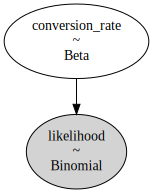

In [5]:
pm.model_to_graphviz(conversion_rate_website_a)

Then we just sample with `pm.sample()`:

In [13]:
with conversion_rate_website_a:
    conversion_rate_idata_a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


And then plot our posterior belief in conversion rate for Website A that shows:

* The mean estimate for `conversion_rate`.
* The 94% HDI - i.e. where 94% of our belief is concentrated around.
* Most importantly, the *uncertainty* in our estimate.

<AxesSubplot:title={'center':'conversion_rate'}>

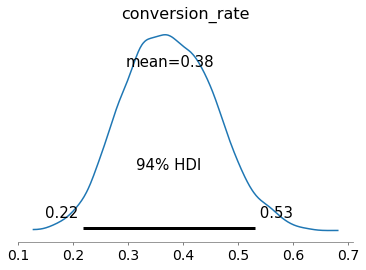

In [14]:
az.plot_posterior(conversion_rate_idata_a, var_names=["conversion_rate"])

array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

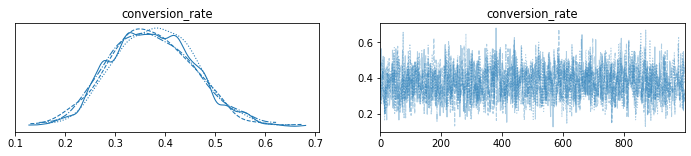

In [15]:
az.plot_trace(conversion_rate_idata_a, var_names=["conversion_rate"])

### Part 2: The A/B test

1. Calculate the point value of percentage conversion from `pandas` or plain Python and draw a conclusion on which website is better.
2. As a professional statistician, you have to provide advice - just not code. Based on the point estimates, would you feel comfortable telling your boss Website B is better (or worse)?
3. Use your Bayesian model to also estimate the conversion rate with uncertainity. Use a forest plot to compare the results from the two models. If your boss asked which website has higher conversion, what would you advise now? How did your confidence-level in your recommendation change?

Again, finding the percentage conversion of Website B using `pandas` is super simple:

In [16]:
websites["Website B"].mean()

0.45

Naively, I could say that Website A is better since it has a slightly higher conversion rate at 50%. However, I wouldn't feel comfortable doing so as the point estimates don't show the *uncertainty* inherent in the estimate. It's possible that each website is converting relatively the same number of people and that there aren't systematic differences between the two. However, to answer that, we need to compare the posterior distributions of each (which we'll do in `PyMC`!)

In [17]:
with pm.Model() as conversion_rate_website_b:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(websites["Website B"]),
        p=conversion_rate,
        observed=websites["Website B"].sum()
    )

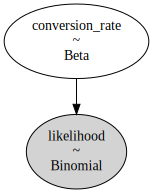

In [18]:
pm.model_to_graphviz(conversion_rate_website_b)

In [19]:
with conversion_rate_website_b:
    conversion_rate_idata_b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


<AxesSubplot:title={'center':'conversion_rate'}>

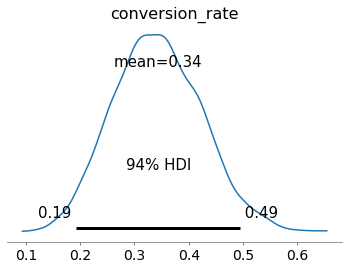

In [20]:
az.plot_posterior(conversion_rate_idata_b, var_names=["conversion_rate"])

`plot_forest()` is pretty neat! We pass an `InferenceData` object to `data` (or a list of them), which contains our estimates from the sampler. Then, we specify how we want to visualize it, followed by what variables we want to plot. `model_names` just gives more descriptive names for the legend and `combined=True` plots the estimates across all chains.

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

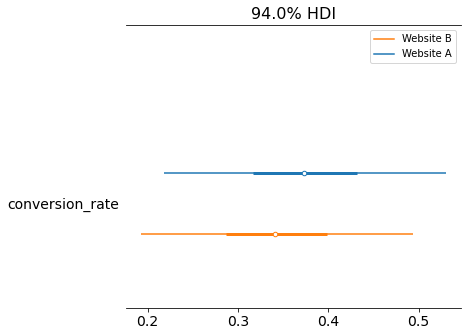

In [23]:
az.plot_forest(
    data=[conversion_rate_idata_a, conversion_rate_idata_b],
    kind="forestplot",
    var_names=["conversion_rate"],
    model_names=["Website A", "Website B"],
    combined=True
)

Based on the forest plot above, I would tell my boss that conversion rate for Website A is likely higher. However, I would still convey that it isn't much better given the uncertainty we see in both estimates. What changed my confidence level is looking at the distributions for each posterior.

### Part 3: Rerun your analysis with more data

In [25]:
websites = pd.read_csv("data/websites_5000_samples.csv")
websites.shape

(5000, 2)

Below I specify the model for Website A:

In [26]:
website_a = websites["Website A"]

In [27]:
with pm.Model() as conversion_rate_website_a:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(website_a),
        p=conversion_rate,
        observed=website_a.sum()
    )

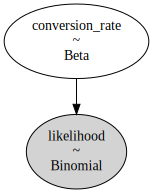

In [29]:
pm.model_to_graphviz(conversion_rate_website_a)

In [30]:
with conversion_rate_website_a:
    conversion_rate_idata_a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


<AxesSubplot:title={'center':'conversion_rate'}>

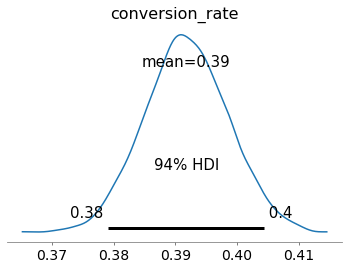

In [31]:
az.plot_posterior(conversion_rate_idata_a, var_names=["conversion_rate"])

array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

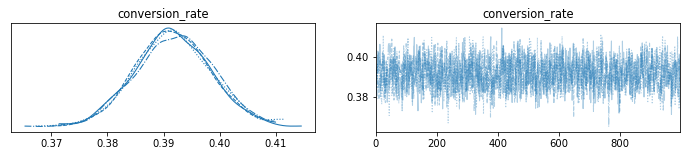

In [32]:
az.plot_trace(conversion_rate_idata_a, var_names=["conversion_rate"])

And here I do the same thing but for Website B:

In [33]:
website_b = websites["Website B"]

In [34]:
with pm.Model() as conversion_rate_website_b:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(website_b),
        p=conversion_rate,
        observed=website_b.sum()
    )

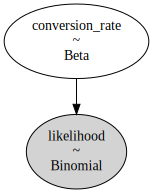

In [35]:
pm.model_to_graphviz(conversion_rate_website_b)

In [38]:
with conversion_rate_website_b:
    conversion_rate_idata_b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


<AxesSubplot:title={'center':'conversion_rate'}>

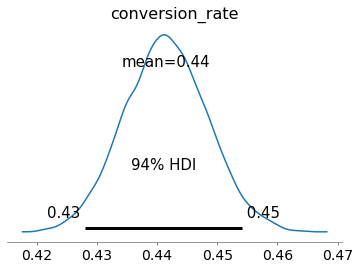

In [39]:
az.plot_posterior(conversion_rate_idata_b, var_names=["conversion_rate"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

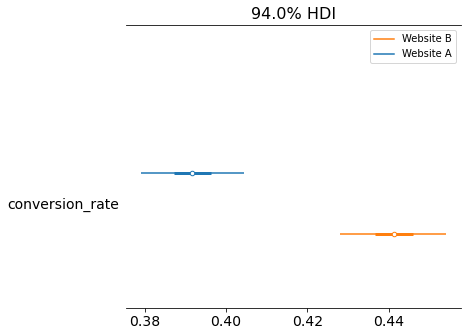

In [41]:
az.plot_forest(
    data=[conversion_rate_idata_a, conversion_rate_idata_b],
    kind="forestplot",
    var_names=["conversion_rate"],
    model_names=["Website A", "Website B"],
    combined=True
)

Now that we have more data, it's *very* clear that Website B has the higher conversion rate. Based on this, I would adjust my previous cautionary recommendation of Website A to Website B.

### Part 4: See the effect of more data

1. Before writing any code, pause and ponder for a minute: would you be more certain or less certain with more data?
2. Use a forest plot to compare your estimation from 20 samples with 5000. Do the results match your intuition?

I'd be more certain with more data as it gives me more information about the problem I'm interested in.

Below, I compare my estimate of 20 samples vs the one with 5000 for Website A:

In [42]:
websites_small = pd.read_csv("data/websites.csv")
websites_large = pd.read_csv("data/websites_5000_samples.csv")

In [43]:
with pm.Model() as conversion_rate_small_a:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(websites_small["Website A"]),
        p=conversion_rate,
        observed=websites_small["Website A"].sum()
    )

In [44]:
with conversion_rate_small_a:
    conversion_rate_idata_small_a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [45]:
with pm.Model() as conversion_rate_large_a:
    conversion_rate = pm.Beta("conversion_rate", alpha=2, beta=10)
    
    likelihood = pm.Binomial(
        name="likelihood",
        n=len(websites_large["Website A"]),
        p=conversion_rate,
        observed=websites_large["Website A"].sum()
    )

In [46]:
with conversion_rate_large_a:
    conversion_rate_idata_large_a = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

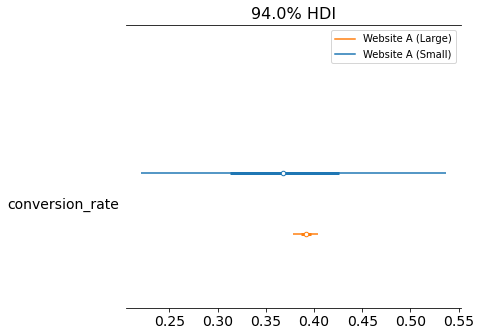

In [47]:
pm.plot_forest(
    data=[conversion_rate_idata_small_a, conversion_rate_idata_large_a],
    kind="forestplot",
    var_names=["conversion_rate"],
    model_names=["Website A (Small)", "Website A (Large)"],
    combined=True
)

The results match my intuition. With less data, we're more uncertain about the conversion rate of Website A, which is indicated by the tails of the interval. However, with more data, we are very certain that the conversion rate for Website A ranges from about 37% - 41%.

## Exercise 3: Reading docs

Utilizing the `ArviZ` documentation, determine how to:

1. Generate a rankplot from the output of `pm.sample()`.
2. Convert the forest plot into a ridge plot.
3. **Optional:** Access the posterior group of the returned `InferenceData`, and get the mean of the samples across all dimensions.

This is a plot of a "rankplot". Don't fully understand the intuition behind it so I should look through the documentation later: https://arviz-devs.github.io/arviz/api/generated/arviz.plot_rank.html#arviz.plot_rank

<AxesSubplot:title={'center':'conversion_rate'}, xlabel='Rank (all chains)', ylabel='Chain'>

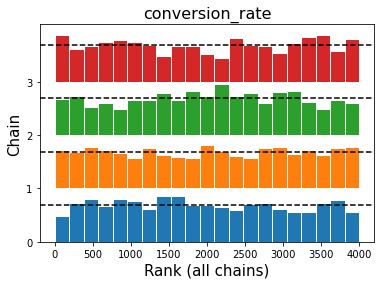

In [48]:
az.plot_rank(conversion_rate_idata_large_a, var_names=["conversion_rate"])

Converting the forest plot to a ridge plot is just changing the argument passed to `kind`:

array([<AxesSubplot:>], dtype=object)

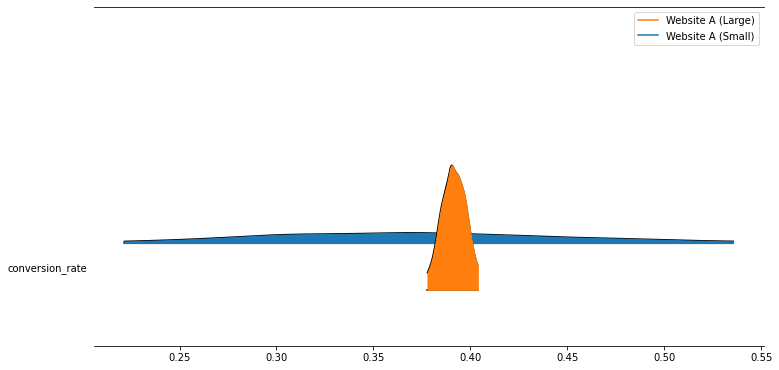

In [51]:
az.plot_forest(
    data=[conversion_rate_idata_small_a, conversion_rate_idata_large_a],
    kind="ridgeplot",
    var_names=["conversion_rate"],
    model_names=["Website A (Small)", "Website A (Large)"],
    combined=True
)

It seems that the ridge plot plots the posterior as a smoothed KDE, so we can get a better idea of the uncertainty/confidence in our estimate.

Finally, getting the mean across the posterior for all chains is easy to do - we just access the `InferenceData` object with familiar Python indexing:

In [55]:
np.mean(conversion_rate_idata_large_a.posterior["conversion_rate"])

<xarray.DataArray 'conversion_rate' ()>
array(0.39165623)

Or, from the exercise solutions, we can do this (which I find more succinct):

In [60]:
conversion_rate_idata_large_a.posterior.mean()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    conversion_rate  float64 0.3917